# Libraries

In [1]:
# Core
import kagglehub
import os
import random
import yaml
import numpy as np
import cv2

# Visualization
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

# Load and save

In [2]:
# Download dataset
root_dir = kagglehub.dataset_download("orvile/human-bone-fractures-image-dataset-hbfmid")
print("Path to dataset files:", root_dir)

for root, dirs, files in os.walk(root_dir):
    # Indentation level
    level = root.replace(root_dir, "").count(os.sep)
    indent = "  " * level
    
    # Print folder names
    print(f"{indent}{os.path.basename(root)}/")

Path to dataset files: C:\Users\Chris\.cache\kagglehub\datasets\orvile\human-bone-fractures-image-dataset-hbfmid\versions\1
1/
  Human Bone Fractures Multi-modal Image Dataset (HBFMID)/
    Bone Fractures Detection/
      test/
        images/
        labels/
      train/
        images/
        labels/
      valid/
        images/
        labels/


In [3]:
yaml_path = os.path.join(root_dir,
                        "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
                        "Bone Fractures Detection",
                        "data.yaml")

print("YAML:", yaml_path)

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

print(data)

YAML: C:\Users\Chris\.cache\kagglehub\datasets\orvile\human-bone-fractures-image-dataset-hbfmid\versions\1\Human Bone Fractures Multi-modal Image Dataset (HBFMID)\Bone Fractures Detection\data.yaml
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 10, 'names': ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse'], 'roboflow': {'workspace': 'iubat-i4ldm', 'project': 'bon-fracture-detection', 'version': 2, 'license': 'Private', 'url': 'https://app.roboflow.com/iubat-i4ldm/bon-fracture-detection/2'}}


In [4]:
# Flatten and print YAML content simply
print("train:", data["train"])
print("val:", data["val"])
print("test:", data["test"])

# Number of classes
print("\nnc:", data["nc"])

# Labels
print("\nnames:")
for i, name in enumerate(data["names"]):
    print(f"  {i}: {name}")

# Source and background of this project
print("\nroboflow:")
for k, v in data["roboflow"].items():
    print(f"  {k}: {v}")

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 10

names:
  0: Comminuted
  1: Greenstick
  2: Healthy
  3: Linear
  4: Oblique Displaced
  5: Oblique
  6: Segmental
  7: Spiral
  8: Transverse Displaced
  9: Transverse

roboflow:
  workspace: iubat-i4ldm
  project: bon-fracture-detection
  version: 2
  license: Private
  url: https://app.roboflow.com/iubat-i4ldm/bon-fracture-detection/2


# Preprocessing

## Sample images

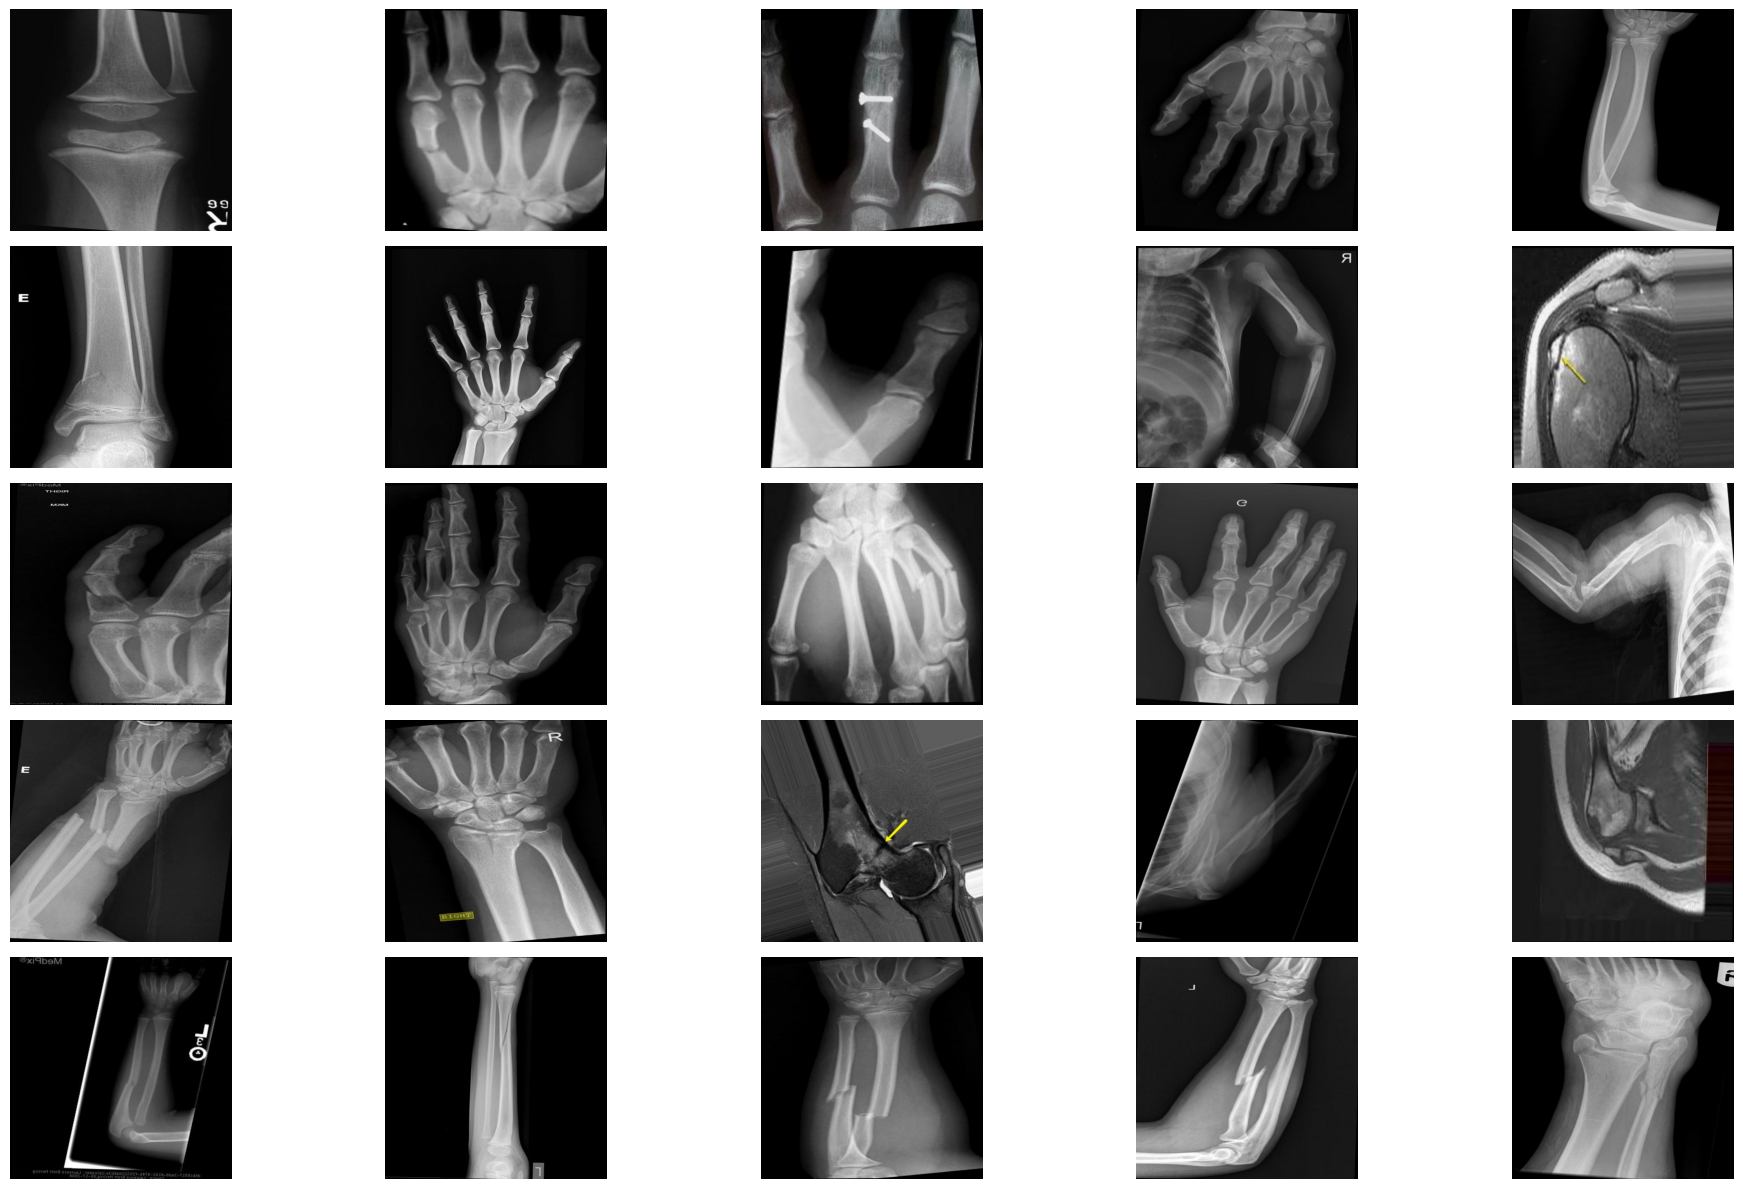

In [5]:
# Sample images
train_images_dir = os.path.join(
    root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "train",
    "images"
)

# Get list of image files
image_files = [f for f in os.listdir(train_images_dir) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pick 25 random images
sample_files = random.sample(image_files, min(25, len(image_files)))

plt.figure(figsize=(20,12))

for i, img_name in enumerate(sample_files, 1):
    img_path = os.path.join(train_images_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Sample images with YOLO bounding boxes

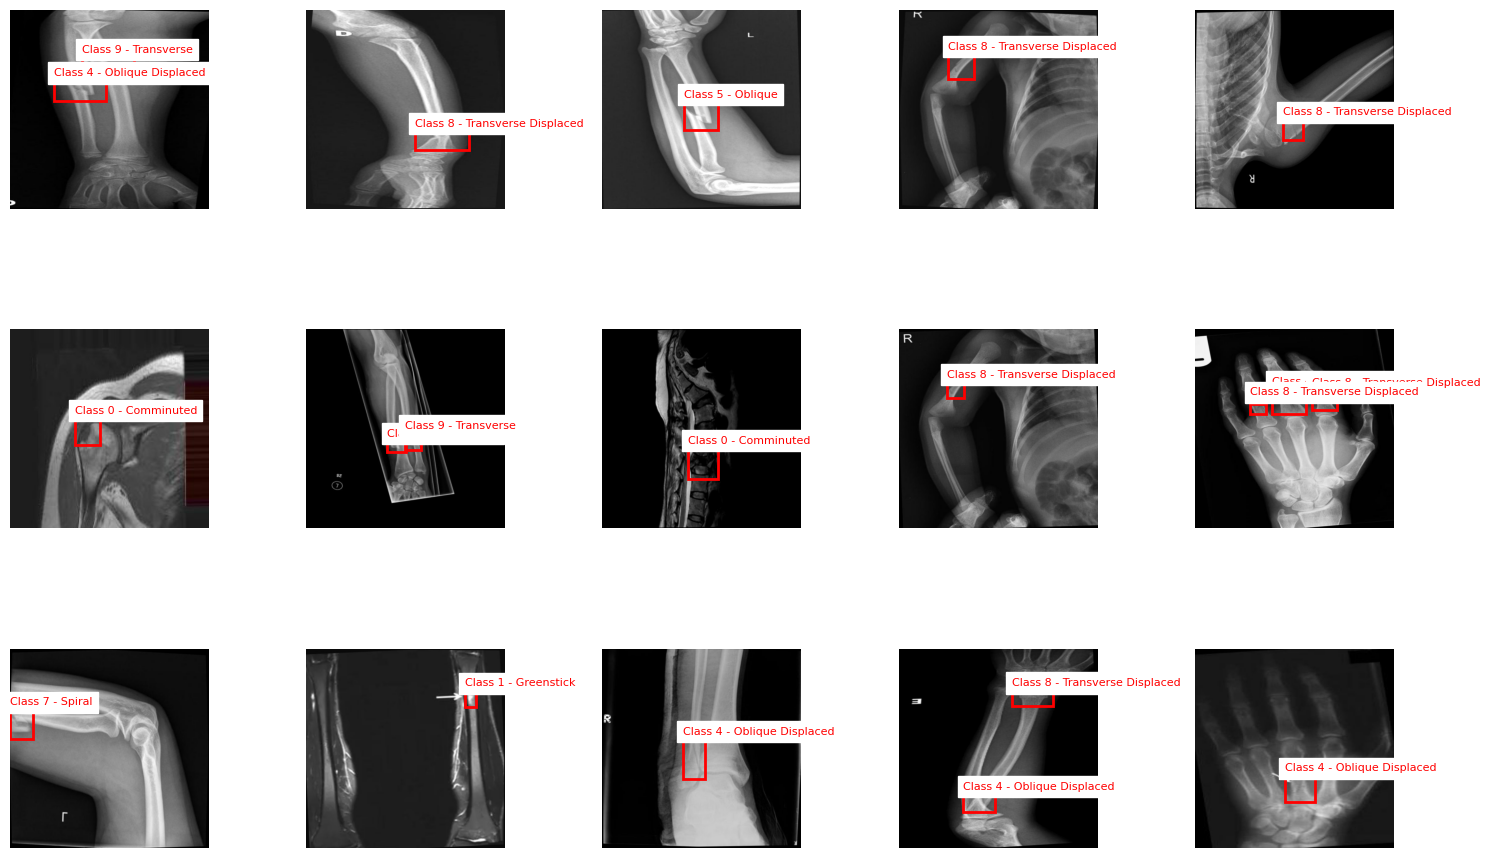

In [6]:
# Sample images with bounding boxes
train_labels_dir = os.path.join(
    root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection",
    "train",
    "labels")

# Get image files
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Random sample
sample_files = random.sample(image_files, min(15, len(image_files)))

plt.figure(figsize=(15, 10))

for i, img_name in enumerate(sample_files, 1):
    img_path = os.path.join(train_images_dir, img_name)
    label_path = os.path.join(train_labels_dir, img_name.rsplit('.', 1)[0] + ".txt")

    # Open image
    img = Image.open(img_path)
    w, h = img.size  # image width, height

    # Create plot
    ax = plt.subplot(3, 5, i)
    ax.imshow(img)

    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for idx, line in enumerate(f):
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, box_width, box_height = map(float, parts)

                    # Convert from YOLO format to pixel coordinates
                    x_center *= w
                    y_center *= h
                    box_width *= w
                    box_height *= h

                    x_min = x_center - box_width / 2
                    y_min = y_center - box_height / 2

                    # Create rectangle
                    rect = patches.Rectangle(
                        (x_min, y_min), box_width, box_height,
                        linewidth=2, edgecolor='red', facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(x_min,
                            y_min - 5 - (12 * idx),
                            f"Class {int(class_id)} - {data['names'][int(class_id)]}",
                            color='red',
                            fontsize=8,
                            backgroundcolor='white'                        )

    ax.axis('off')

plt.tight_layout()
plt.show()

# MV

## Select images

In [7]:
# Dataset base path
base_dir = os.path.join(
    root_dir,
    "Human Bone Fractures Multi-modal Image Dataset (HBFMID)",
    "Bone Fractures Detection")

# Define image + label paths
train_images = os.path.join(base_dir, "train", "images")
train_labels = os.path.join(base_dir, "train", "labels")

val_images = os.path.join(base_dir, "valid", "images")
val_labels = os.path.join(base_dir, "valid", "labels")

test_images = os.path.join(base_dir, "test", "images")
test_labels = os.path.join(base_dir, "test", "labels")

# Use these for selection:
images_dir = train_images
labels_dir = train_labels

print("Using images_dir:", images_dir)
print("Using labels_dir:", labels_dir)

Using images_dir: C:\Users\Chris\.cache\kagglehub\datasets\orvile\human-bone-fractures-image-dataset-hbfmid\versions\1\Human Bone Fractures Multi-modal Image Dataset (HBFMID)\Bone Fractures Detection\train\images
Using labels_dir: C:\Users\Chris\.cache\kagglehub\datasets\orvile\human-bone-fractures-image-dataset-hbfmid\versions\1\Human Bone Fractures Multi-modal Image Dataset (HBFMID)\Bone Fractures Detection\train\labels


In [8]:
# -------------------------------------------------------------
# STEP 1 — Select 1 IMAGE PER CLASS
# -------------------------------------------------------------

print("\n===== STEP 1: LOADING IMAGES =====")

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

class_names = data["names"]
num_classes = data["nc"]

# Map images to their class using YOLO labels
image_class_map = {i: [] for i in range(num_classes)}

for img_file in os.listdir(images_dir):
    if not img_file.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    label_file = img_file.rsplit(".", 1)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            line = f.readline().strip().split()
            if len(line) >= 1:
                class_id = int(line[0])
                image_class_map[class_id].append(img_file)

# Sort for deterministic selection
for cls in image_class_map:
    image_class_map[cls] = sorted(image_class_map[cls])

# Choose 1 image per class
selected_images = {}
for cls, files in image_class_map.items():
    if len(files) > 0:
        selected_images[cls] = random.sample(files, 1)[0]

print("\nSelected images per class:")
for cls, img_name in selected_images.items():
    print(f"  Class {cls} ({class_names[cls]}): {img_name}")

# Load images into memory (BGR)
loaded_images = {}
for cls, img_name in selected_images.items():
    img_path = os.path.join(images_dir, img_name)
    img_bgr = cv2.imread(img_path)
    loaded_images[cls] = img_bgr

print("\n===== STEP 1 COMPLETE =====")


===== STEP 1: LOADING IMAGES =====

Selected images per class:
  Class 0 (Comminuted): 14_mri_0_151_jpeg.rf.d7d99eb43ede874637f2bf0cf63165ab.jpg
  Class 1 (Greenstick): 13_jpg.rf.5c601aab5d4653d2b7c40c80de3429cf.jpg
  Class 2 (Healthy): 37_jpg.rf.c4363266e6d613745e7fd45c45c77aa2.jpg
  Class 3 (Linear): 236_jpg.rf.d63ac035fb6c6d410ce41b8b8f9e3b85.jpg
  Class 4 (Oblique Displaced): 166_jpg.rf.94ebb5fe004fb275451afec2d2e38acc.jpg
  Class 5 (Oblique): 127_jpg.rf.6158ee3ab5d75c90f62291de080d94ef.jpg
  Class 6 (Segmental): 116_jpg.rf.36e5cd8e6c002aa9b57d18c4069f86cb.jpg
  Class 7 (Spiral): 104_jpg.rf.dd53625e1454ca4393ba59e7ed749c23.jpg
  Class 8 (Transverse Displaced): 136_jpg.rf.308af87e6d1510c5446d83578ed5648d.jpg
  Class 9 (Transverse): 61_jpg.rf.08c73461942709a66fe7a8691efe01f4.jpg

===== STEP 1 COMPLETE =====


## Convert to grayscale, compute histogram & CDF

In [9]:
# -------------------------------------------------------------
# STEP 2 — CONVERT TO GRAYSCALE + COMPUTE HISTOGRAM & CDF
# -------------------------------------------------------------

print("\n===== STEP 2: GRAYSCALE + HISTOGRAM + CDF =====")

gray_images = {}
histograms = {}
cdfs = {}

for cls, img_bgr in loaded_images.items():

    if img_bgr is None:
        print(f"[ERROR] Could not load image for class {cls}. Skipping.")
        continue

    # Convert to grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_images[cls] = gray

    # Compute histogram
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256]).flatten()
    histograms[cls] = hist

    # Compute CDF
    cdf = hist.cumsum()
    cdf = cdf / cdf[-1]  # normalize to 1
    cdfs[cls] = cdf

print("\nGrayscale images, histograms, and CDFs computed.")
print("===== STEP 2 COMPLETE =====")


===== STEP 2: GRAYSCALE + HISTOGRAM + CDF =====

Grayscale images, histograms, and CDFs computed.
===== STEP 2 COMPLETE =====


## Visualization after grayscale


===== STEP 3: VISUALIZATION (N × 3 TRANSPOSED) =====


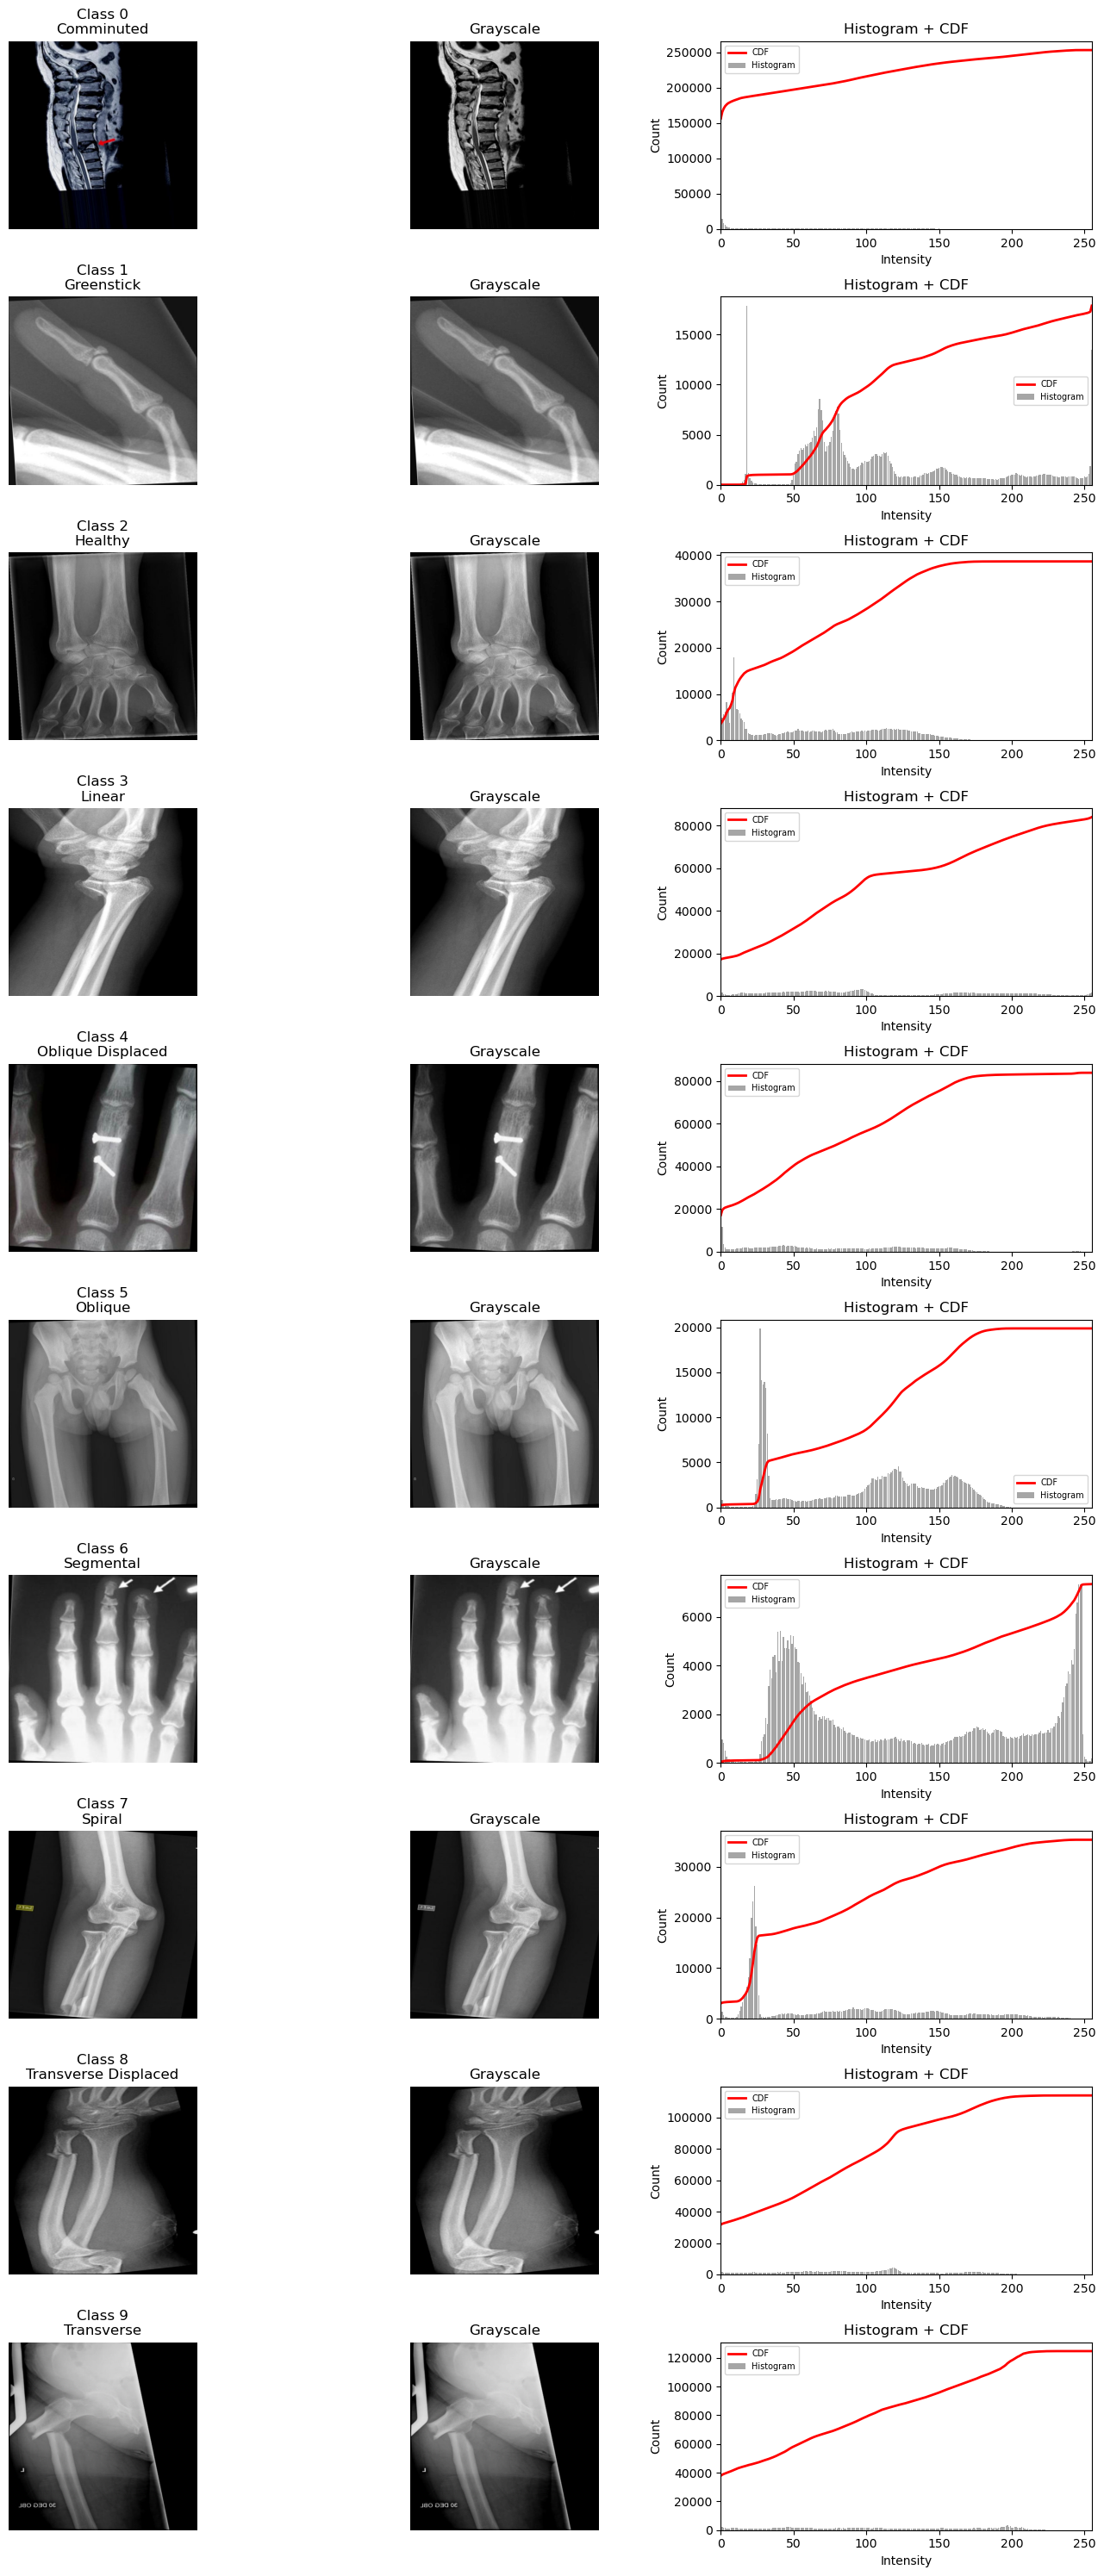


===== STEP 3 COMPLETE (TRANSPOSED) =====


In [10]:
# -------------------------------------------------------------
# STEP 3 — VISUALIZATION: N × 3 MATRIX (TRANSPOSED)
# -------------------------------------------------------------

print("\n===== STEP 3: VISUALIZATION (N × 3 TRANSPOSED) =====")

num_classes_to_plot = len(selected_images)
plt.figure(figsize=(14, 3 * num_classes_to_plot))  # Taller figure for rows

for row_index, cls in enumerate(selected_images):

    # ---------------------
    # Column 1: Original RGB
    # ---------------------
    plt.subplot(num_classes_to_plot, 3, row_index * 3 + 1)
    rgb = cv2.cvtColor(loaded_images[cls], cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.title(f"Class {cls}\n{class_names[cls]}")
    plt.axis("off")

    # ---------------------
    # Column 2: Grayscale
    # ---------------------
    plt.subplot(num_classes_to_plot, 3, row_index * 3 + 2)
    plt.imshow(gray_images[cls], cmap="gray")
    plt.title("Grayscale")
    plt.axis("off")

    # ---------------------
    # Column 3: Histogram + CDF
    # ---------------------
    plt.subplot(num_classes_to_plot, 3, row_index * 3 + 3)
    hist = histograms[cls]
    cdf = cdfs[cls]

    plt.bar(np.arange(256), hist, color="gray", alpha=0.7, label="Histogram")
    plt.plot(cdf * hist.max(), color="red", linewidth=2, label="CDF")
    plt.xlim([0, 255])
    plt.title("Histogram + CDF")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\n===== STEP 3 COMPLETE (TRANSPOSED) =====")

## Histogram equalization

### Global HE computation

In [11]:
# -------------------------------------------------------------
# GLOBAL HISTOGRAM EQUALIZATION — COMPUTE
# -------------------------------------------------------------

print("\n===== GLOBAL HISTOGRAM EQUALIZATION: COMPUTE =====")

equalized_global = {}
hist_global = {}
cdf_global = {}

for cls, gray in gray_images.items():
    # Apply global histogram equalization
    g_eq = cv2.equalizeHist(gray)
    equalized_global[cls] = g_eq

    # Histogram
    hist_g = cv2.calcHist([g_eq], [0], None, [256], [0, 256]).flatten()
    hist_global[cls] = hist_g

    # CDF
    cdf_g = hist_g.cumsum()
    cdf_g = cdf_g / cdf_g[-1]
    cdf_global[cls] = cdf_g

print("Global histogram equalization (image, hist, CDF) computed for all classes.")
print("===== DONE =====")


===== GLOBAL HISTOGRAM EQUALIZATION: COMPUTE =====
Global histogram equalization (image, hist, CDF) computed for all classes.
===== DONE =====


### Global HE visualization


===== GLOBAL HISTOGRAM EQUALIZATION: VISUALIZATION =====


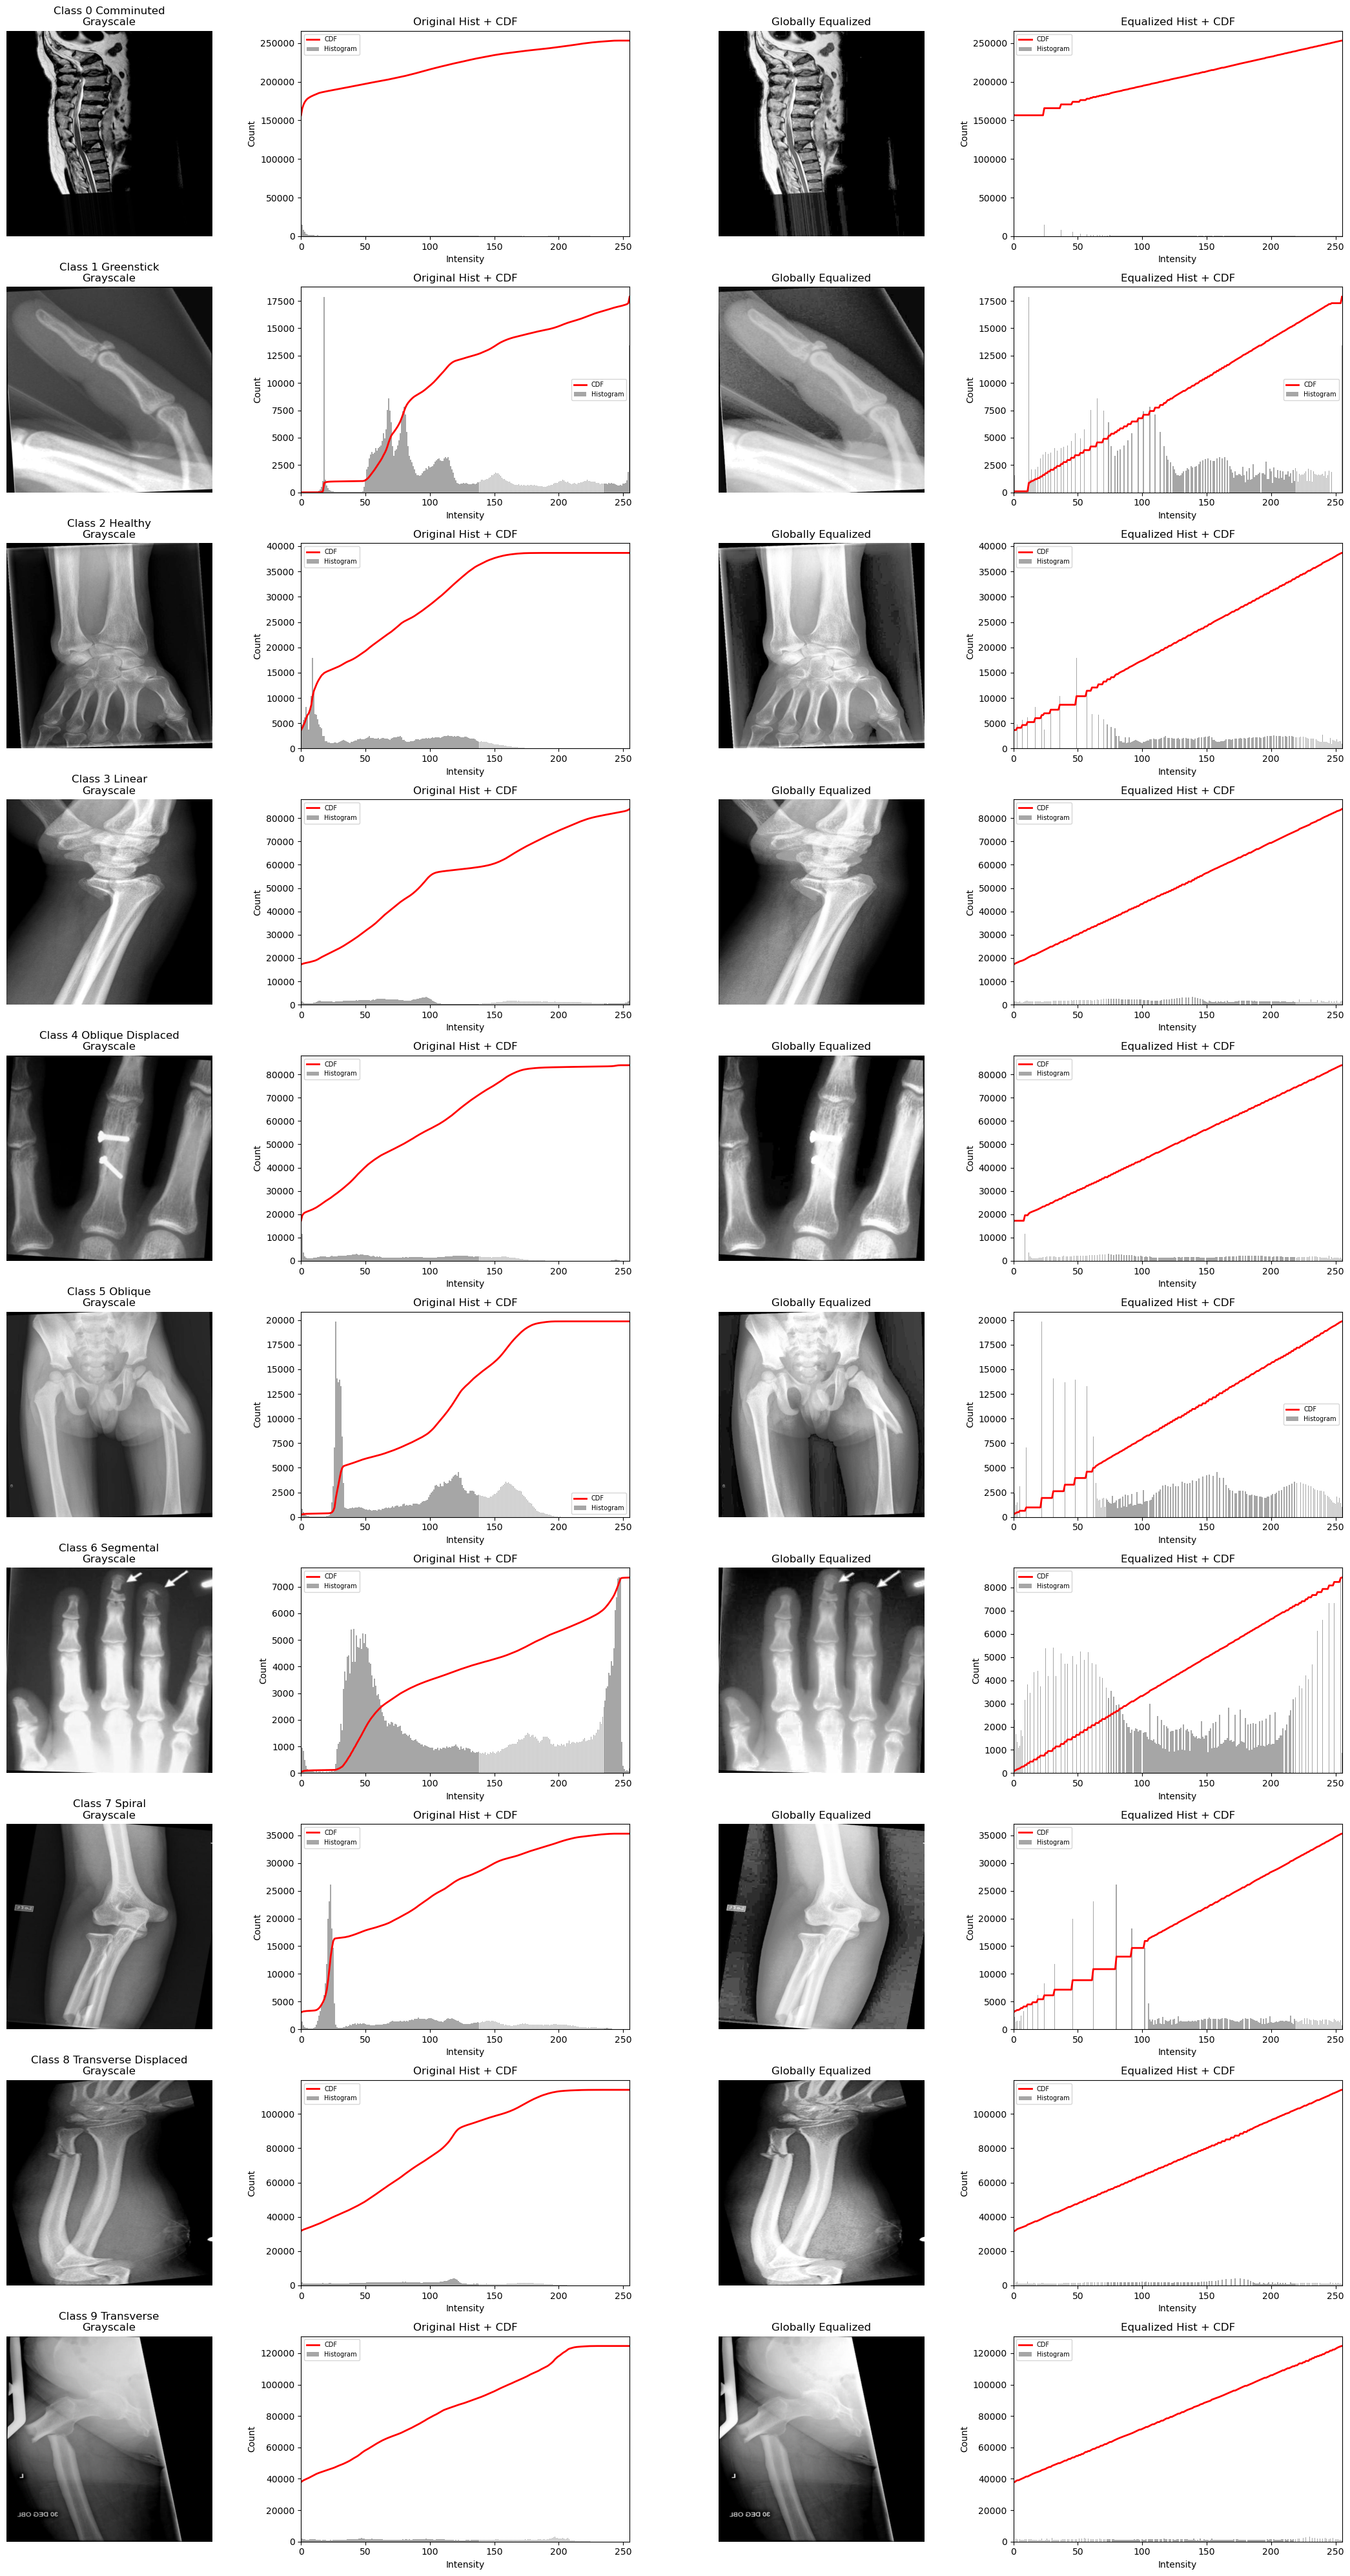


===== GLOBAL HISTEQ VISUALIZATION DONE =====


In [12]:
# -------------------------------------------------------------
# GLOBAL HISTOGRAM EQUALIZATION — VISUALIZE
# -------------------------------------------------------------

print("\n===== GLOBAL HISTOGRAM EQUALIZATION: VISUALIZATION =====")

num_classes_to_plot = len(selected_images)
plt.figure(figsize=(22, 4 * num_classes_to_plot))

for row_index, cls in enumerate(selected_images):

    # 1) Grayscale before
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 1)
    plt.imshow(gray_images[cls], cmap="gray")
    plt.title(f"Class {cls} {class_names[cls]}\nGrayscale")
    plt.axis("off")

    # 2) Original histogram + CDF
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 2)
    hist = histograms[cls]
    cdf  = cdfs[cls]
    plt.bar(np.arange(256), hist, color="gray", alpha=0.7, label="Histogram")
    plt.plot(cdf * hist.max(), color="red", linewidth=2, label="CDF")
    plt.title("Original Hist + CDF")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

    # 3) Globally equalized image
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 3)
    plt.imshow(equalized_global[cls], cmap="gray")
    plt.title("Globally Equalized")
    plt.axis("off")

    # 4) Equalized histogram + CDF
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 4)
    hist_g = hist_global[cls]
    cdf_g  = cdf_global[cls]
    plt.bar(np.arange(256), hist_g, color="gray", alpha=0.7, label="Histogram")
    plt.plot(cdf_g * hist_g.max(), color="red", linewidth=2, label="CDF")
    plt.title("Equalized Hist + CDF")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\n===== GLOBAL HISTEQ VISUALIZATION DONE =====")

### Contrast Limited Adaptive Histogram Equalization (CLAHE) computation

In [13]:
# -------------------------------------------------------------
# CLAHE — COMPUTE
# -------------------------------------------------------------

print("\n===== CLAHE: COMPUTE =====")

equalized_clahe = {}
hist_clahe = {}
cdf_clahe = {}

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for cls, gray in gray_images.items():
    # Apply CLAHE
    c_eq = clahe.apply(gray)
    equalized_clahe[cls] = c_eq

    # Histogram
    hist_c = cv2.calcHist([c_eq], [0], None, [256], [0, 256]).flatten()
    hist_clahe[cls] = hist_c

    # CDF
    cdf_c = hist_c.cumsum()
    cdf_c = cdf_c / cdf_c[-1]
    cdf_clahe[cls] = cdf_c

print("CLAHE (image, hist, CDF) computed for all classes.")
print("===== DONE =====")


===== CLAHE: COMPUTE =====
CLAHE (image, hist, CDF) computed for all classes.
===== DONE =====


### Contrast Limited Adaptive Histogram Equalization (CLAHE) visualization


===== CLAHE: VISUALIZATION =====


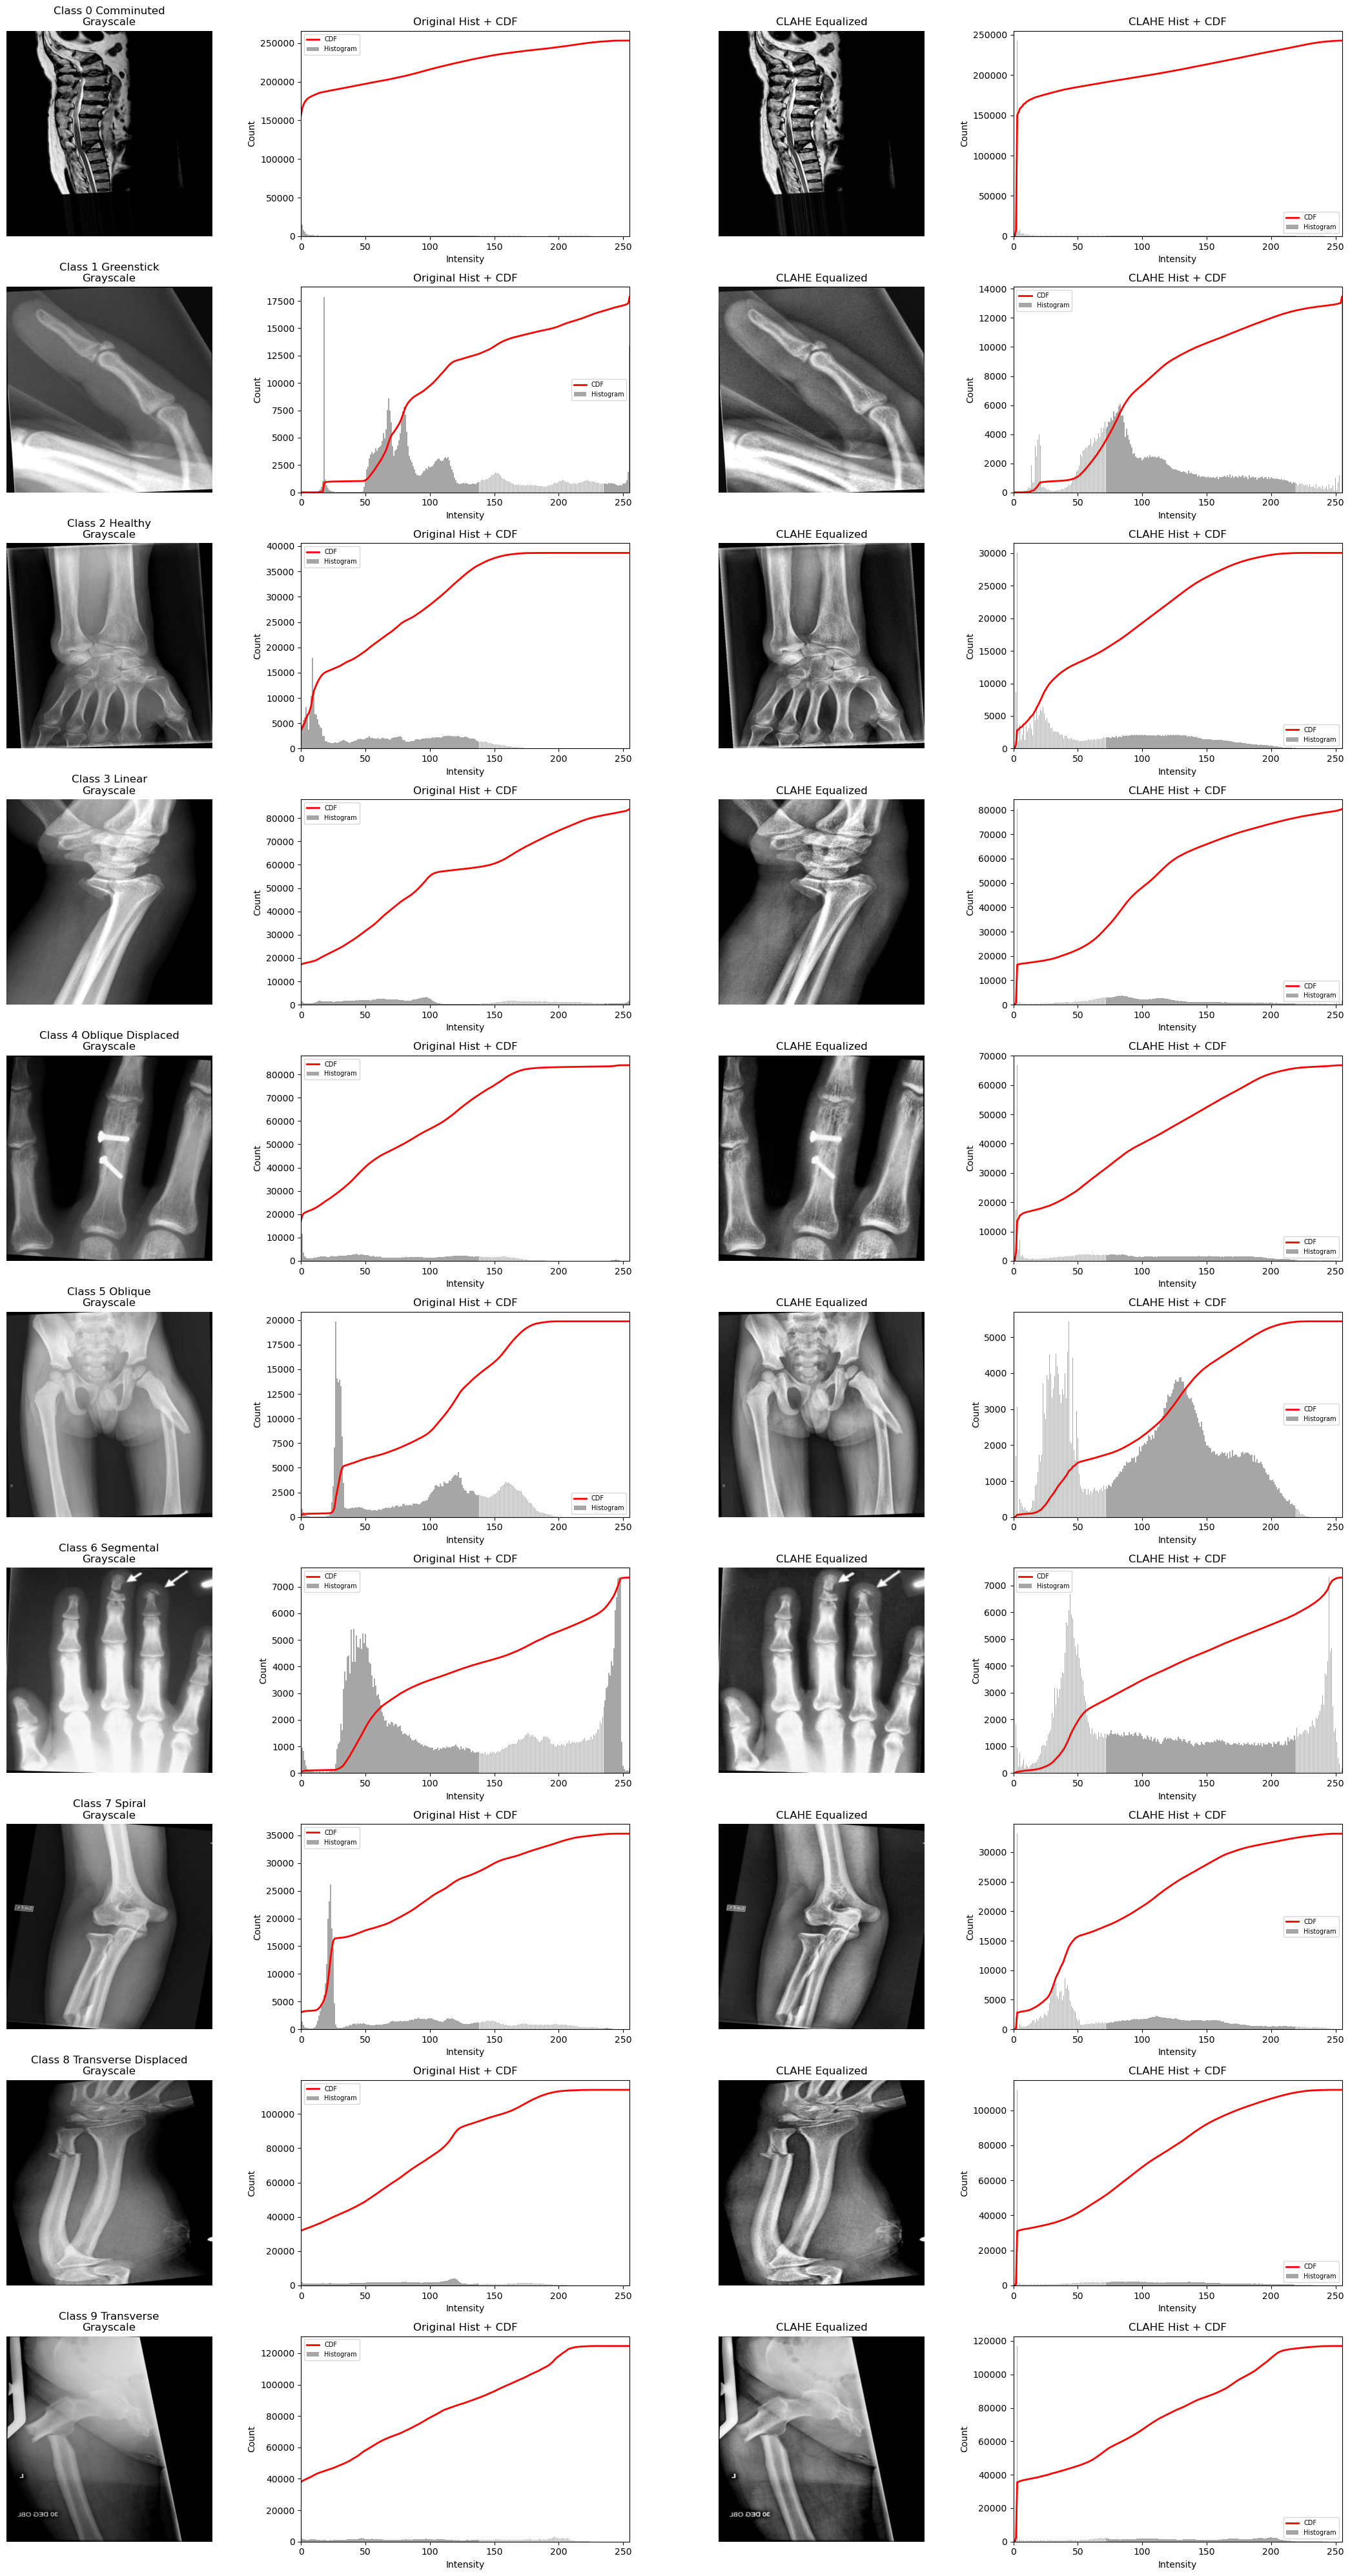


===== CLAHE VISUALIZATION DONE =====


In [14]:
# -------------------------------------------------------------
# CLAHE — VISUALIZE
# -------------------------------------------------------------

print("\n===== CLAHE: VISUALIZATION =====")

num_classes_to_plot = len(selected_images)
plt.figure(figsize=(22, 4 * num_classes_to_plot))

for row_index, cls in enumerate(selected_images):

    # 1) Grayscale before
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 1)
    plt.imshow(gray_images[cls], cmap="gray")
    plt.title(f"Class {cls} {class_names[cls]}\nGrayscale")
    plt.axis("off")

    # 2) Original histogram + CDF
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 2)
    hist = histograms[cls]
    cdf  = cdfs[cls]
    plt.bar(np.arange(256), hist, color="gray", alpha=0.7, label="Histogram")
    plt.plot(cdf * hist.max(), color="red", linewidth=2, label="CDF")
    plt.title("Original Hist + CDF")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

    # 3) CLAHE image
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 3)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title("CLAHE Equalized")
    plt.axis("off")

    # 4) CLAHE histogram + CDF
    plt.subplot(num_classes_to_plot, 4, row_index * 4 + 4)
    hist_c = hist_clahe[cls]
    cdf_c  = cdf_clahe[cls]
    plt.bar(np.arange(256), hist_c, color="gray", alpha=0.7, label="Histogram")
    plt.plot(cdf_c * hist_c.max(), color="red", linewidth=2, label="CDF")
    plt.title("CLAHE Hist + CDF")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\n===== CLAHE VISUALIZATION DONE =====")

### Histogram comparison

In [ ]:
# -------------------------------------------------------------
# STEP 5 — N × 3 HISTOGRAM + CDF MATRIX
# Col 1: Original  | Col 2: Global EQ | Col 3: CLAHE
# -------------------------------------------------------------

print("\n===== STEP 5: N × 3 HISTOGRAM + CDF MATRIX =====")

num_classes = len(selected_images)
plt.figure(figsize=(18, 4 * num_classes))

for row_index, cls in enumerate(selected_images):

    # ---------------------------------------
    # Column 1 — Original Histogram + CDF
    # ---------------------------------------
    plt.subplot(num_classes, 3, row_index * 3 + 1)
    hist_o = histograms[cls]
    cdf_o  = cdfs[cls]

    plt.bar(np.arange(256), hist_o, color="gray", alpha=0.7, label="Hist")
    plt.plot(cdf_o * hist_o.max(), color="red", linewidth=2, label="CDF")
    plt.title(f"Class {cls}: {class_names[cls]}\nOriginal")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

    # ---------------------------------------
    # Column 2 — Global Equalized Histogram + CDF
    # ---------------------------------------
    plt.subplot(num_classes, 3, row_index * 3 + 2)
    hist_g = hist_global[cls]
    cdf_g  = cdf_global[cls]

    plt.bar(np.arange(256), hist_g, color="blue", alpha=0.7, label="Hist")
    plt.plot(cdf_g * hist_g.max(), color="red", linewidth=2, label="CDF")
    plt.title("Global Equalized")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

    # ---------------------------------------
    # Column 3 — CLAHE Histogram + CDF
    # ---------------------------------------
    plt.subplot(num_classes, 3, row_index * 3 + 3)
    hist_c = hist_clahe[cls]
    cdf_c  = cdf_clahe[cls]

    plt.bar(np.arange(256), hist_c, color="green", alpha=0.7, label="Hist")
    plt.plot(cdf_c * hist_c.max(), color="red", linewidth=2, label="CDF")
    plt.title("CLAHE")
    plt.xlim([0, 255])
    plt.xlabel("Intensity")
    plt.ylabel("Count")
    plt.legend(fontsize=7)

plt.tight_layout()
plt.show()

print("\n===== HISTOGRAM + CDF MATRIX COMPLETE =====")


===== STEP 5: N × 3 HISTOGRAM + CDF MATRIX =====


## Filtering & Edge detection

### Gaussian filter

In [ ]:
# -------------------------------------------------------------
# STEP X — GAUSSIAN SMOOTHING WITH 3×3, 5×5, 9×9 (ON CLAHE)
# -------------------------------------------------------------

print("\n===== GAUSSIAN SMOOTHING (CLAHE INPUT) =====")

gauss_3 = {}
gauss_5 = {}
gauss_9 = {}

for cls, img in equalized_clahe.items():
    # Gaussian kernels must be odd numbers, as required by OpenCV
    gauss_3[cls] = cv2.GaussianBlur(img, (3, 3), 0)
    gauss_5[cls] = cv2.GaussianBlur(img, (5, 5), 0)
    gauss_9[cls] = cv2.GaussianBlur(img, (9, 9), 0)

print("Gaussian smoothing completed for kernel sizes 3×3, 5×5, and 9×9.")

In [ ]:
# -------------------------------------------------------------
# GAUSSIAN VISUALIZATION — N × 4 MATRIX
# -------------------------------------------------------------

num_classes = len(selected_images)
plt.figure(figsize=(20, 4 * num_classes))

for row_index, cls in enumerate(selected_images):

    # Column 1: CLAHE image
    plt.subplot(num_classes, 4, row_index * 4 + 1)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    plt.axis("off")

    # Column 2: Gaussian 3×3
    plt.subplot(num_classes, 4, row_index * 4 + 2)
    plt.imshow(gauss_3[cls], cmap="gray")
    plt.title("Gaussian 3×3")
    plt.axis("off")

    # Column 3: Gaussian 5×5
    plt.subplot(num_classes, 4, row_index * 4 + 3)
    plt.imshow(gauss_5[cls], cmap="gray")
    plt.title("Gaussian 5×5")
    plt.axis("off")

    # Column 4: Gaussian 9×9
    plt.subplot(num_classes, 4, row_index * 4 + 4)
    plt.imshow(gauss_9[cls], cmap="gray")
    plt.title("Gaussian 9×9")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("\n===== GAUSSIAN SMOOTHING VISUALIZATION COMPLETE =====")

### Median filtering

In [ ]:
# -------------------------------------------------------------
# STEP X — MEDIAN FILTERING WITH 3×3, 5×5, 7×7 (ON CLAHE)
# -------------------------------------------------------------

print("\n===== MEDIAN FILTERING (CLAHE INPUT) =====")

median_3 = {}
median_5 = {}
median_7 = {}

for cls, img in equalized_clahe.items():
    median_3[cls] = cv2.medianBlur(img, 3)
    median_5[cls] = cv2.medianBlur(img, 5)
    median_7[cls] = cv2.medianBlur(img, 7)

print("Median filtering completed for kernel sizes 3×3, 5×5, and 7×7.")


In [ ]:
# -------------------------------------------------------------
# MEDIAN FILTERING VISUALIZATION — N × 4 MATRIX
# -------------------------------------------------------------

num_classes = len(selected_images)
plt.figure(figsize=(20, 4 * num_classes))

for row_index, cls in enumerate(selected_images):

    # Column 1: CLAHE image
    plt.subplot(num_classes, 4, row_index * 4 + 1)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    plt.axis("off")

    # Column 2: Median 3×3
    plt.subplot(num_classes, 4, row_index * 4 + 2)
    plt.imshow(median_3[cls], cmap="gray")
    plt.title("Median 3×3")
    plt.axis("off")

    # Column 3: Median 5×5
    plt.subplot(num_classes, 4, row_index * 4 + 3)
    plt.imshow(median_5[cls], cmap="gray")
    plt.title("Median 5×5")
    plt.axis("off")

    # Column 4: Median 7×7
    plt.subplot(num_classes, 4, row_index * 4 + 4)
    plt.imshow(median_7[cls], cmap="gray")
    plt.title("Median 7×7")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("\n===== MEDIAN FILTERING VISUALIZATION COMPLETE =====")


### Bilateral filtering

In [ ]:
# -------------------------------------------------------------
# STEP X — BILATERAL FILTERING (THREE LEVELS)
# -------------------------------------------------------------

print("\n===== BILATERAL FILTERING (CLAHE INPUT) =====")

bilat_light = {}
bilat_med   = {}
bilat_strong = {}

for cls, img in equalized_clahe.items():
    
    # Light smoothing
    bilat_light[cls] = cv2.bilateralFilter(img, d=5, sigmaColor=25, sigmaSpace=25)
    
    # Medium smoothing
    bilat_med[cls]   = cv2.bilateralFilter(img, d=7, sigmaColor=50, sigmaSpace=50)
    
    # Strong smoothing
    bilat_strong[cls] = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

print("Bilateral filtering completed at light, medium, and strong levels.")


In [ ]:
# -------------------------------------------------------------
# BILATERAL FILTERING VISUALIZATION — N × 4 MATRIX
# -------------------------------------------------------------

num_classes = len(selected_images)
plt.figure(figsize=(20, 4 * num_classes))

for row_index, cls in enumerate(selected_images):
    
    # Column 1: CLAHE image
    plt.subplot(num_classes, 4, row_index * 4 + 1)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    plt.axis("off")
    
    # Column 2: Bilateral (Light)
    plt.subplot(num_classes, 4, row_index * 4 + 2)
    plt.imshow(bilat_light[cls], cmap="gray")
    plt.title("Bilateral (Light)")
    plt.axis("off")
    
    # Column 3: Bilateral (Medium)
    plt.subplot(num_classes, 4, row_index * 4 + 3)
    plt.imshow(bilat_med[cls], cmap="gray")
    plt.title("Bilateral (Medium)")
    plt.axis("off")
    
    # Column 4: Bilateral (Strong)
    plt.subplot(num_classes, 4, row_index * 4 + 4)
    plt.imshow(bilat_strong[cls], cmap="gray")
    plt.title("Bilateral (Strong)")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("\n===== BILATERAL FILTERING VISUALIZATION COMPLETE =====")


### Laplacian

In [ ]:
# -------------------------------------------------------------
# STEP X — LAPLACIAN EDGE ENHANCEMENT (WEAK, STRONG, VERY STRONG)
# -------------------------------------------------------------

print("\n===== LAPLACIAN FILTERING (CLAHE INPUT) =====")

laplace_weak = {}
laplace_strong = {}
laplace_very_strong = {}

kernel_weak = np.array([[0, -1, 0],
                        [-1, 4, -1],
                        [0, -1, 0]], dtype=np.float32)

kernel_strong = np.array([[-1, -1, -1],
                          [-1,  8, -1],
                          [-1, -1, -1]], dtype=np.float32)

# Very strong Laplacian kernel (more aggressive)
kernel_very_strong = np.array([[1, 1, 1],
                               [1, -8, 1],
                               [1, 1, 1]], dtype=np.float32)

for cls, img in equalized_clahe.items():

    img_float = img.astype(np.float32)

    # Weak Laplacian
    lap_w = cv2.filter2D(img_float, -1, kernel_weak)
    laplace_weak[cls] = cv2.convertScaleAbs(lap_w)

    # Strong Laplacian
    lap_s = cv2.filter2D(img_float, -1, kernel_strong)
    laplace_strong[cls] = cv2.convertScaleAbs(lap_s)

    # Very Strong Laplacian
    lap_vs = cv2.filter2D(img_float, -1, kernel_very_strong)
    laplace_very_strong[cls] = cv2.convertScaleAbs(lap_vs)

print("Laplacian (weak, strong, very strong) computed for all classes.")


In [ ]:
# -------------------------------------------------------------
# LAPLACIAN VISUALIZATION — N × 4 MATRIX (WITH VERY STRONG)
# -------------------------------------------------------------

num_classes = len(selected_images)
plt.figure(figsize=(22, 4 * num_classes))

for row_index, cls in enumerate(selected_images):

    # Column 1 — CLAHE
    plt.subplot(num_classes, 4, row_index * 4 + 1)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    plt.axis("off")

    # Column 2 — Weak Laplacian
    plt.subplot(num_classes, 4, row_index * 4 + 2)
    plt.imshow(laplace_weak[cls], cmap="gray")
    plt.title("Laplacian (Weak)")
    plt.axis("off")

    # Column 3 — Strong Laplacian
    plt.subplot(num_classes, 4, row_index * 4 + 3)
    plt.imshow(laplace_strong[cls], cmap="gray")
    plt.title("Laplacian (Strong)")
    plt.axis("off")

    # Column 4 — Very Strong Laplacian
    plt.subplot(num_classes, 4, row_index * 4 + 4)
    plt.imshow(laplace_very_strong[cls], cmap="gray")
    plt.title("Laplacian (Very Strong)")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("\n===== LAPLACIAN VISUALIZATION COMPLETE =====")

### Unsharp masking

In [ ]:
# -------------------------------------------------------------
# STEP X — UNSHARP MASKING: LIGHT, MEDIUM, STRONG
# -------------------------------------------------------------

print("\n===== UNSHARP MASKING (LIGHT, MEDIUM, STRONG) =====")

unsharp_light = {}
unsharp_medium = {}
unsharp_strong = {}

alpha_light = 1.0
alpha_med   = 2.0
alpha_strong = 3.0

for cls, img in equalized_clahe.items():

    img_float = img.astype(np.float32)

    # Gaussian blur for base low-frequency component
    blurred = cv2.GaussianBlur(img_float, (5, 5), 0)

    # High-frequency component
    mask = img_float - blurred

    # Light sharpening
    sharp_l = img_float + alpha_light * mask
    unsharp_light[cls] = cv2.convertScaleAbs(sharp_l)

    # Medium sharpening
    sharp_m = img_float + alpha_med * mask
    unsharp_medium[cls] = cv2.convertScaleAbs(sharp_m)

    # Strong sharpening
    sharp_s = img_float + alpha_strong * mask
    unsharp_strong[cls] = cv2.convertScaleAbs(sharp_s)

print("Unsharp masking completed for all three levels.")


In [ ]:
# -------------------------------------------------------------
# UNSHARP MASKING VISUALIZATION — N × 4 MATRIX
# -------------------------------------------------------------

num_classes = len(selected_images)
plt.figure(figsize=(20, 4 * num_classes))

for row_index, cls in enumerate(selected_images):

    # Column 1 — CLAHE image
    plt.subplot(num_classes, 4, row_index * 4 + 1)
    plt.imshow(equalized_clahe[cls], cmap="gray")
    plt.title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    plt.axis("off")

    # Column 2 — Unsharp Light
    plt.subplot(num_classes, 4, row_index * 4 + 2)
    plt.imshow(unsharp_light[cls], cmap="gray")
    plt.title("Unsharp (Light, α=1)")
    plt.axis("off")

    # Column 3 — Unsharp Medium
    plt.subplot(num_classes, 4, row_index * 4 + 3)
    plt.imshow(unsharp_medium[cls], cmap="gray")
    plt.title("Unsharp (Medium, α=2)")
    plt.axis("off")

    # Column 4 — Unsharp Strong
    plt.subplot(num_classes, 4, row_index * 4 + 4)
    plt.imshow(unsharp_strong[cls], cmap="gray")
    plt.title("Unsharp (Strong, α=3)")
    plt.axis("off")

plt.tight_layout()
plt.show()

print("\n===== UNSHARP MASKING VISUALIZATION COMPLETE =====")

### Filter comparison

In [ ]:
# -------------------------------------------------------------
# STEP X — COMPARE ALL FILTERING METHODS (SORTED, NO CLAHE)
# -------------------------------------------------------------

print("\n===== FILTER QUALITY COMPARISON (SORTED, CLAHE EXCLUDED) =====")

def sobel_edge_strength(image):
    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    return np.mean(mag)

def residual_std(base, filtered):
    diff = filtered.astype(np.float32) - base.astype(np.float32)
    return np.std(diff)

# Remove CLAHE from comparison
filters_no_clahe = {
    "Gauss_3x3": gauss_3,
    "Gauss_5x5": gauss_5,
    "Gauss_9x9": gauss_9,

    "Median_3x3": median_3,
    "Median_5x5": median_5,
    "Median_7x7": median_7,

    "Bilateral_Light": bilat_light,
    "Bilateral_Medium": bilat_med,
    "Bilateral_Strong": bilat_strong,

    "Laplace_Weak": laplace_weak,
    "Laplace_Strong": laplace_strong,
    "Laplace_VeryStrong": laplace_very_strong,

    "Unsharp_Light": unsharp_light,
    "Unsharp_Medium": unsharp_medium,
    "Unsharp_Strong": unsharp_strong,
}

eps = 1e-6  # prevent division by zero

for cls in selected_images:

    print(f"\n===== Class {cls}: {class_names[cls]} =====")
    print(f"{'Filter':20s} | {'EdgeStr':>10s} | {'NoiseStd':>10s} | {'Score':>10s}")
    print("-" * 65)

    clahe_img = equalized_clahe[cls]

    rows = []
    for name, fmap in filters_no_clahe.items():
        img = fmap[cls]

        E = sobel_edge_strength(img)
        N = residual_std(clahe_img, img)
        score = E / (N + eps)

        rows.append((name, E, N, score))

    # Sort best to worst by score
    rows_sorted = sorted(rows, key=lambda x: x[3], reverse=True)

    # Print sorted results
    for name, E, N, score in rows_sorted:
        print(f"{name:20s} | {E:10.4f} | {N:10.4f} | {score:10.4f}")

print("\n===== SORTED FILTER COMPARISON COMPLETE =====")

## Edge detection

### Sobel Edge Detector

In [ ]:
# -------------------------------------------------------------
# STEP X — SOBEL ON CLAHE AND BEST FILTER PER CLASS
# -------------------------------------------------------------

# Best filter per class based on your score table
best_filters = {
    0: "Bilateral_Light",
    1: "Unsharp_Light",
    2: "Median_3x3",
    3: "Unsharp_Light",
    4: "Median_3x3",
    5: "Unsharp_Light",
    6: "Bilateral_Light",
    7: "Unsharp_Light",
    8: "Unsharp_Light",
    9: "Bilateral_Light",
}

# Mapping filter names to filter dictionaries
filter_dict = {
    "Gauss_3x3": gauss_3,
    "Gauss_5x5": gauss_5,
    "Gauss_9x9": gauss_9,
    "Median_3x3": median_3,
    "Median_5x5": median_5,
    "Median_7x7": median_7,
    "Bilateral_Light": bilat_light,
    "Bilateral_Medium": bilat_med,
    "Bilateral_Strong": bilat_strong,
    "Unsharp_Light": unsharp_light,
    "Unsharp_Medium": unsharp_medium,
    "Unsharp_Strong": unsharp_strong,}

def sobel_edges(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    mag = (mag / mag.max() * 255).astype(np.uint8)
    return mag

# Produce one figure per class
for cls in range(10):

    clahe_img = equalized_clahe[cls]
    best_name = best_filters[cls]
    best_img = filter_dict[best_name][cls]

    sobel_clahe = sobel_edges(clahe_img)
    sobel_best = sobel_edges(best_img)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(clahe_img, cmap="gray")
    axes[0].set_title(f"Class {cls} — {class_names[cls]}\nCLAHE")
    axes[0].axis("off")

    axes[1].imshow(sobel_clahe, cmap="gray")
    axes[1].set_title("Sobel(CLAHE)")
    axes[1].axis("off")

    axes[2].imshow(best_img, cmap="gray")
    axes[2].set_title(f"{best_name}")
    axes[2].axis("off")

    axes[3].imshow(sobel_best, cmap="gray")
    axes[3].set_title(f"Sobel({best_name})")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


#### Thresholding


#### Morphological Operations

#### Connectected Component Analysis

#### Skeletonization

#### Fracture detection

### Canny Edge Detector

In [ ]:
# -------------------------------------------------------------
# STEP X — CANNY (FIXED + ADAPTIVE) FOR CLAHE AND BEST FILTER
# -------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
import cv2

# ---- CANNY HELPERS --------------------------------------------------------

def canny_fixed(img, low=50, high=150):
    return cv2.Canny(img, low, high)

def canny_adaptive(img):
    median = np.median(img)
    low = int(max(0, 0.66 * median))
    high = int(min(255, 1.33 * median))
    return cv2.Canny(img, low, high)


# ---- BEST FILTERS PER CLASS -----------------------------------------------

best_filters = {
    0: "Bilateral_Light",
    1: "Unsharp_Light",
    2: "Median_3x3",
    3: "Unsharp_Light",
    4: "Median_3x3",
    5: "Unsharp_Light",
    6: "Bilateral_Light",
    7: "Unsharp_Light",
    8: "Unsharp_Light",
    9: "Bilateral_Light",
}

filter_dict = {
    "Gauss_3x3": gauss_3,
    "Gauss_5x5": gauss_5,
    "Gauss_9x9": gauss_9,
    "Median_3x3": median_3,
    "Median_5x5": median_5,
    "Median_7x7": median_7,
    "Bilateral_Light": bilat_light,
    "Bilateral_Medium": bilat_med,
    "Bilateral_Strong": bilat_strong,
    "Unsharp_Light": unsharp_light,
    "Unsharp_Medium": unsharp_medium,
    "Unsharp_Strong": unsharp_strong,
}

# ---- MAIN LOOP ------------------------------------------------------------

for cls in range(10):

    clahe_img = equalized_clahe[cls]
    best_name = best_filters[cls]
    best_img = filter_dict[best_name][cls]

    # Canny outputs
    canny_fixed_clahe    = canny_fixed(clahe_img)
    canny_adaptive_clahe = canny_adaptive(clahe_img)

    canny_fixed_best     = canny_fixed(best_img)
    canny_adaptive_best  = canny_adaptive(best_img)

    # Plotting (6 images per class)
    fig, axes = plt.subplots(1, 6, figsize=(28, 5))

    axes[0].imshow(clahe_img, cmap="gray")
    axes[0].set_title(f"Class {cls}: {class_names[cls]}\nCLAHE")
    axes[0].axis("off")

    axes[1].imshow(canny_fixed_clahe, cmap="gray")
    axes[1].set_title("Canny Fixed\n(CLAHE)")
    axes[1].axis("off")

    axes[2].imshow(canny_adaptive_clahe, cmap="gray")
    axes[2].set_title("Canny Adaptive\n(CLAHE)")
    axes[2].axis("off")

    axes[3].imshow(best_img, cmap="gray")
    axes[3].set_title(f"{best_name}")
    axes[3].axis("off")

    axes[4].imshow(canny_fixed_best, cmap="gray")
    axes[4].set_title(f"Canny Fixed\n({best_name})")
    axes[4].axis("off")

    axes[5].imshow(canny_adaptive_best, cmap="gray")
    axes[5].set_title(f"Canny Adaptive\n({best_name})")
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()

#### Morphological Operations

#### Connectected Component Analysis

#### Skeletonization

#### Fracture detection